In [1]:
import os

In [2]:
os.environ['AOC_SESSION'] = '53616c7465645f5f2390b1a2a8981260b4addfea3af95b32f034711559bdec07664fba46dcaafbd454968913573814f5'

In [3]:
os.chdir("..")
os.path.abspath(".")

'/Users/rbuhr/projects/adventofcode/2019'

In [4]:
from aocd import get_data
from collections import defaultdict
import random

In [5]:
import dijkstar

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 9]

In [7]:
from intcode import Intcode

In [8]:
data = get_data(year=2019, day=15)

In [9]:
NORTH = 1
SOUTH = 2
WEST = 3 
EAST= 4

WALL = 0
OK = 1
STOP = 2

In [10]:
def get_next_position(direction, x, y):
    if direction == NORTH:
        return x, y+1
    elif direction == SOUTH:
        return x, y-1
    elif direction == WEST:
        return x-1, y
    elif direction == EAST:
        return x+1, y

In [123]:
def turn_right(direction):
    if direction == NORTH:
        return EAST
    elif direction == SOUTH:
        return WEST
    elif direction == EAST:
        return SOUTH
    elif direction == WEST:
        return NORTH


def turn_around(direction):
    return turn_right(turn_right(direction))


def turn_left(direction):
    return turn_right(turn_around(direction))


def turn_random(direction):
    while True:
        d = random.choice(range(1, 5))
        if d != direction:
            return d

In [142]:
def run(data, limit=float('inf')):
    counter = 0
    positions = defaultdict(int)
    walls = {}
    # starting condition
    x, y = (0, 0)
    test_positions = {}
    positions = {(x, y)}
    ic = Intcode(data, input_queue=[])
    direction = EAST
    oxygen = {}
    
    def test_step(ic, direction):
        ic.input_queue.append(direction)
        ic.run()
        result = ic.output_queue.pop()
        # reverse that step if successful
        if result != WALL:
            ic.input_queue.append(turn_around(direction))
            ic.run()
        return result
    
    while counter < limit:
        # test each direction for map
        for d in [NORTH, EAST, SOUTH, WEST]:
            r = test_step(ic, d)
            next_pos = get_next_position(d, x, y)
            if r == 1:
                test_positions[next_pos] = "-"
            elif r == 2:
                test_positions[next_pos] = "$"
            elif r == 0:
                test_positions[next_pos] = "#"
        
        # decide where to go
        if test_step(ic, turn_left(direction)):
            direction = turn_left(direction)
        elif not test_step(ic, direction):
            direction = turn_right(direction)
        
        ic.input_queue.append(direction)
        ic.run()
        result = ic.output_queue.pop()
        if result == 0:
            walls[(x, y)] = "#"
            continue
        
        x, y = get_next_position(direction, x, y)
        positions.add((x, y))
        
        if result == 2:
            oxygen[(x, y)] = "$"
        if (x, y) == (0, 0):
            break
        counter += 1
    oxygen = [k for k, v in oxygen.items() if v == "$"]
    return positions, oxygen, ic, x, y, walls, test_positions

In [171]:
def display(positions, start=(0, 0), stop=None, walls=None):
    ok_x, ok_y = zip(*positions)
    ok_x, ok_y = list(ok_x), list(ok_y)
    if walls:
        wall_x, wall_y = zip(*[k for k, v in walls.items() if v == "#"])
        wall_x, wall_y = list(wall_x), list(wall_y)
    else:
        wall_x, wall_y = 0, 0
    min_x, max_x = min(ok_x + wall_x), max(ok_x + wall_x)
    min_y, max_y = min(ok_y + wall_y), max(ok_y + wall_y)
    plt.scatter(ok_x, ok_y, c='orange', marker=".")
    if walls:
        plt.scatter(wall_x, wall_y, c='black', marker="s")
    plt.xticks(list(range(min_x, max_x + 1)))
    plt.yticks(list(range(min_y, max_y + 1)))
    plt.scatter(start[0], start[1], c='blue', marker="o")
    if stop:
        plt.scatter(stop[0], stop[1], c='blue', marker="*")

In [205]:
positions, oxygen, ic, x, y, walls, path  = run(data, 50000)

In [206]:
oxygen

[(-12, -18)]

In [208]:
len(positions)

799

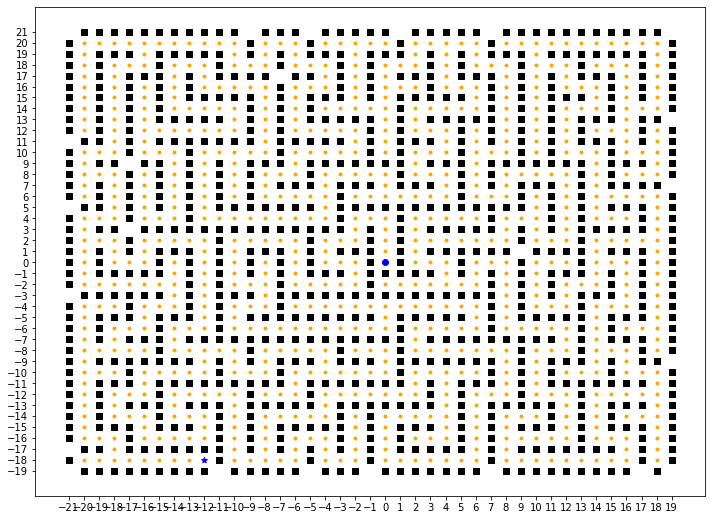

In [207]:
display(positions, walls=path, stop=oxygen[0])

In [209]:
def find_neighbors(point, points):
    adj = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    neighbors = []
    for p in adj:
        neighbors.append((point[0]+p[0], point[1]+p[1]))
    return {n: 1 for n in neighbors if n in points}

In [210]:
graph = dijkstar.Graph()

In [211]:
oxygen[0] in positions

True

In [212]:
for p in positions:
    graph.add_node(p, neighbors=find_neighbors(p, positions))

In [213]:
graph.node_count

799

In [214]:
happy_path = dijkstar.find_path(graph, (0,0), oxygen[0])

In [219]:
oxygen[0] in happy_path.nodes, (0, 0) in happy_path.nodes

(True, True)

In [218]:
len(happy_path.nodes) - 1 # ignore starting point

226

In [197]:
# Part 2 is just finding the shortest path to each point from the oxygen systen, then whatever one has the longest path is time it will take

In [221]:
max([
    len(dijkstar.find_path(graph, pt, oxygen[0]).nodes) - 1
    for pt in positions
])

342